## Image and batch loading

In [1]:
from benchmarking.analysis.analyze_results import *

In [2]:
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking-raw/referenced-experiments/image-loading/")

In [3]:
def parse_logs(output_base_folder: Path, folder_filter: str = "**", filter_by_metadata: Dict[str, List[str]] = None,):
    files = list(output_base_folder.rglob(f"{folder_filter}/results-*.log"))
    data = []
    for working_file_path in tqdm.tqdm(files, total=len(files)):
        results = parse_results_log(working_file_path)
        if len(results) == 0:
            continue
        with (working_file_path.parent / "metadata.json").open("r") as f:
            metadata = json.load(f)
        if filter_by_metadata is not None:
            for k, v in filter_by_metadata.items():
                if metadata[k] not in v:
                    continue
        results = pd.DataFrame.from_records(data=results)

        for k, v in metadata.items():
            if not isinstance(v, (int, float, complex)):
                results[k] = str(v)
            else:
                results[k] = v

        results["source_file"] = working_file_path
        results["run"] = working_file_path.parent.name
#         print(results)
        data.append(results)
    df = pd.concat(data)
    df.groupby
    return df

In [4]:
df_dataset = parse_logs(output_base_folder, folder_filter="*benchmark*")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 169.16it/s]


In [5]:
# df_dataset

In [6]:
unique_runs = np.unique(df_dataset["run"])
batch_sizes = np.unique(df_dataset["batch_size"])
print(f"Batch sizes: {batch_sizes}")
function_names = np.unique(df_dataset["function_name"])
print(f"Function names: {function_names}")


Batch sizes: [   4    8   16   32   64  128  256  512 1024 2048]
Function names: ['just_tensor_load' 'load_random_local_image_to_gpu' 'open_random_batch']


#### Functions explained

- `open_random_batch`  - opens N images from the storage, and stacks them into a batch of size N. To load images, it uses `load_random_local_image_to_gpu`, which just returns the PIL, then it converts it to a tensor, after which the function `just_tensor_load` loads it to the GPU.   

- `load_random_local_image_to_gpu` - opens a random image from the storage and depending on the parameters, loads it to the GPU or returns it in PIL format. 

- `just_tensor_load` - calls the `.cuda(device)` which loads the image to the training device. In this case, a GPU. 

**IMPORTANT**: The execution order is `open_random_batch` -> `load_random_local_image_to_gpu` -> `just_tensor_load`. That said, the measured execution time of `open_random_batch` includes both subsequent functions.

#### Additional resources on GPU data handling

Returns a copy of this object in CUDA memory. If this object is already in CUDA memory and on the correct device,
then no copy is performed and the original object is returned.
However, this first creates CPU tensor, and THEN transfers it to GPU… this is really slow.
Instead, create the tensor directly on the device you want.

check: 
 - https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
 - https://pytorch.org/docs/stable/generated/torch.Tensor.cuda.html
 - https://pytorch.org/docs/stable/notes/cuda.html

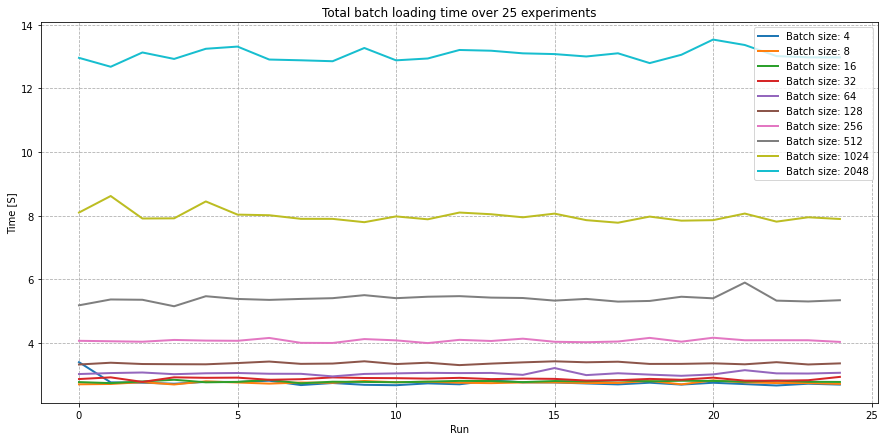

In [7]:
fig, ax = plt.subplots(figsize=(15, 7))
for batch_size in batch_sizes:
    df = df_dataset[(df_dataset["function_name"]=="open_random_batch") & (df_dataset["batch_size"]==batch_size)]
    elapsed = df["elapsed"]
    ax.plot(range(len(elapsed)), elapsed, label=f"Batch size: {batch_size}", linewidth=2)
ax.set_xlabel("Run")
ax.set_ylabel("Time [S]")
ax.set_title("Total batch loading time over 25 experiments")
ax.grid(linestyle="--", which="both")
plt.legend()

Since the batch size increased, experiments don't have the same total number of loaded images, but rather `batch_size * 25` (since each experiment is repeated 25 times). 
In the following plot we show bot axis in log-scale to compensate for that effect.

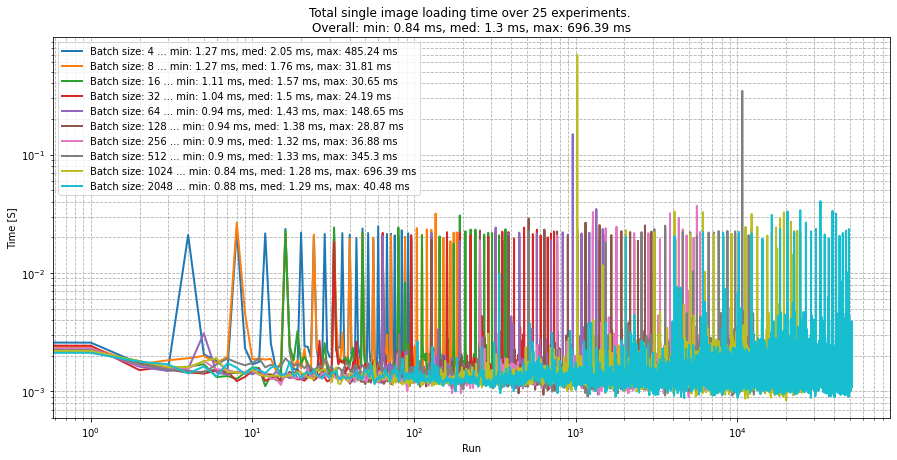

In [8]:
fig, ax = plt.subplots(figsize=(15, 7))
all_elapsed = []
for batch_size in batch_sizes:
    df = df_dataset[(df_dataset["function_name"]=="load_random_local_image_to_gpu") & (df_dataset["batch_size"]==batch_size)]
    elapsed = df["elapsed"]
    all_elapsed.append(np.array(elapsed))
    ax.plot(range(len(elapsed)), 
            elapsed, 
            label=f"Batch size: {batch_size}" 
                  f" ... min: {np.round(min(elapsed) * 1000, 2)} ms, "
                  f"med: {np.round(np.median(elapsed) * 1000, 2)} ms, "
                  f"max: {np.round(max(elapsed) * 1000, 2)} ms",
            linewidth=2)
ax.set_xlabel("Run")
ax.set_ylabel("Time [S]")
all_elapsed = np.hstack(all_elapsed)
ax.set_title("Total single image loading time over 25 experiments. \n"
             f"Overall: min: {np.round(min(all_elapsed) * 1000, 2)} ms, "
             f"med: {np.round(np.median(all_elapsed) * 1000, 2)} ms, "
             f"max: {np.round(max(all_elapsed) * 1000, 2)} ms",)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(linestyle="--", which="both")
plt.legend()

Regardless of the batch size, the loading time of a single image seems stable over time (with a few outliers). The median loading time is 1.3 ms. For instance, given the batch size of 2048, we need to load 2048, and so the time to do this whould be around 1.3 ms * 1000 ms * 2048 = 2.66 S. 

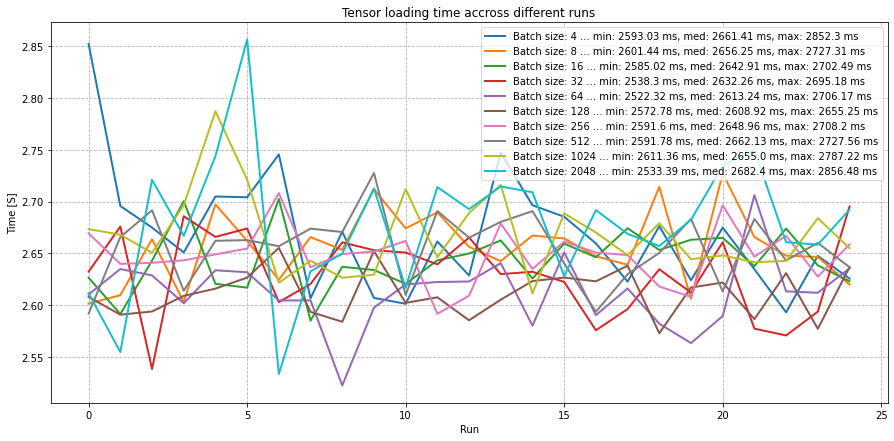

In [9]:
fig, ax = plt.subplots(figsize=(15, 7))
for batch_size in batch_sizes:
    df = df_dataset[(df_dataset["function_name"]=="just_tensor_load") & (df_dataset["batch_size"]==batch_size)]
    elapsed = df["elapsed"]
#     all_elapsed.append(np.array(elapsed))
    ax.plot(range(len(elapsed)), 
            elapsed, 
            label=f"Batch size: {batch_size}" 
                  f" ... min: {np.round(min(elapsed) * 1000, 2)} ms, "
                  f"med: {np.round(np.median(elapsed) * 1000, 2)} ms, "
                  f"max: {np.round(max(elapsed) * 1000, 2)} ms",
            linewidth=2)
#     ax.plot(range(len(elapsed)), elapsed, label=f"Batch size: {batch_size}", linewidth=2)
ax.set_xlabel("Run")
ax.set_ylabel("Time [S]")
ax.set_title("Tensor loading time accross different runs")
ax.grid(linestyle="--", which="both")
plt.legend(loc="upper right")

According to the image above, batch size generaly doesn't have a great impact on the loading time to the GPU, with exception of some outliers. The loading time is between 2.5 and 2.8 seconds.  

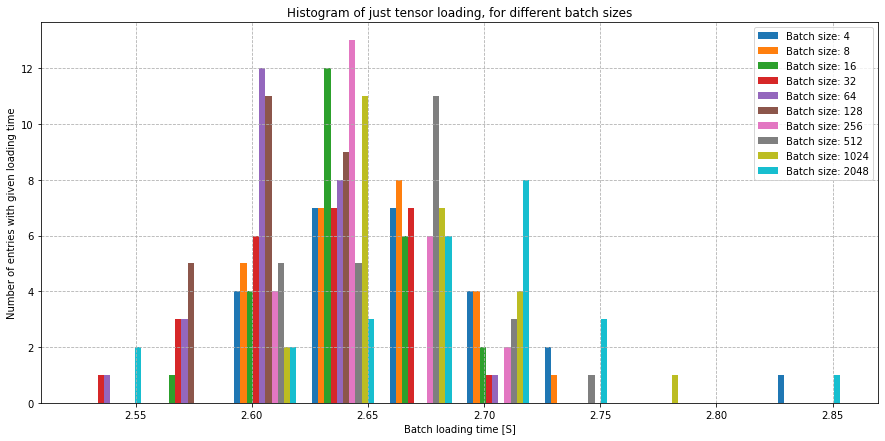

In [10]:
fig, ax = plt.subplots(figsize=(15, 7))
elapsed_all = []
labels = []
for batch_size in batch_sizes:
    df = df_dataset[(df_dataset["function_name"]=="just_tensor_load") & (df_dataset["batch_size"]==batch_size)]
    elapsed_all.append(df["elapsed"])
    labels.append(f"Batch size: {batch_size}")
ax.hist(elapsed_all, bins=10, label=labels)
ax.set_xlabel("Batch loading time [S]")
ax.set_ylabel("Number of entries with given loading time")
ax.set_title("Histogram of just tensor loading, for different batch sizes")
ax.grid(linestyle="--", which="both")
plt.legend()

Again, the same data, displayed as histogram. There seem to be outliers for batch of size 4 and 2048. If we consider the image above, that also includes the time dimension, we assume that this utlier for batch size 4 is due to the training warmup cycle, though we did introduce 15 s waiting time between each experiment. 

2.6614098590798676
2.6562472679652274
2.642908301204443
2.6322602168656886
2.613235993310809
2.6089232098311186
2.648962426930666
2.6621260209940374
2.655000621918589
2.6824027062393725
Median across all: 2.6452940034214407


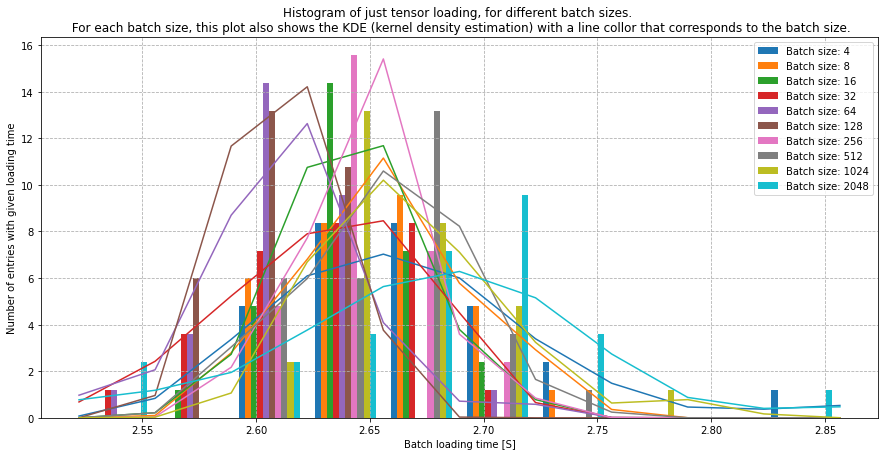

In [11]:
import scipy.stats as stats
fig, ax = plt.subplots(figsize=(15, 7))
elapsed_all = []
labels = []
for batch_size in batch_sizes:
    df = df_dataset[(df_dataset["function_name"]=="just_tensor_load") & (df_dataset["batch_size"]==batch_size)]
    elapsed_all.append(df["elapsed"])
    labels.append(f"Batch size: {batch_size}")
n, x, _  = ax.hist(elapsed_all, bins=10, label=labels, density=True)
ax.set_xlabel("Batch loading time [S]")
ax.set_ylabel("Number of entries with given loading time")
ax.set_title("Histogram of just tensor loading, for different batch sizes. \n For each batch size, this plot also shows the KDE (kernel density estimation) with a line collor that corresponds to the batch size.")
ax.grid(linestyle="--", which="both")
for elapsed in elapsed_all:
    density = stats.gaussian_kde(elapsed)
    ax.plot(x, density(x))
#     print(np.median(elapsed))
plt.legend()
print(f"Median across all: {np.median(elapsed_all)}")

## Sanity check experiment
 - creating a random batch and loading it to the device
 - creating a random batch directly on the device
 
https://pytorch.org/docs/stable/generated/torch.Tensor.cuda.html
 
- Returns a copy of this object in CUDA memory.
- If this object is already in CUDA memory and on the correct device, then no copy is performed and the original object is returned.

In [42]:
output_base_folder = Path("/iarai/home/ivan.svogor/git/storage-benchmarking/benchmark_output/batches-sanity-check/")
df_dataset = parse_logs(output_base_folder, folder_filter="*benchmark*")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 284.67it/s]


In [23]:
unique_runs = np.unique(df_dataset["run"])
batch_sizes = np.unique(df_dataset["batch_size"])
print(f"Batch sizes: {batch_sizes}")
function_names = np.unique(df_dataset["function_name"])
print(f"Function names: {function_names}")


Batch sizes: [   4    8   16   32   64  128  256  512 1024 2048]
Function names: ['just_tensor_load' 'load_random_tensor_on_gpu' 'nothing'
 'open_random_batch']


The function execution order is:
 1. `open_random_batch` - for details see the previous description. However, here, we aren't loading images from the storage, instead, just creating them directly on GPU, meaning, that this function and the following one (2) should have almost the same plot.
 2. `load_random_tensor_on_gpu` - creates a tensor on GPU directly
 3. `just_tensor_load` - loads a tensor to GPU
 
 Therefore `just_tensor_load` time should be negligible!

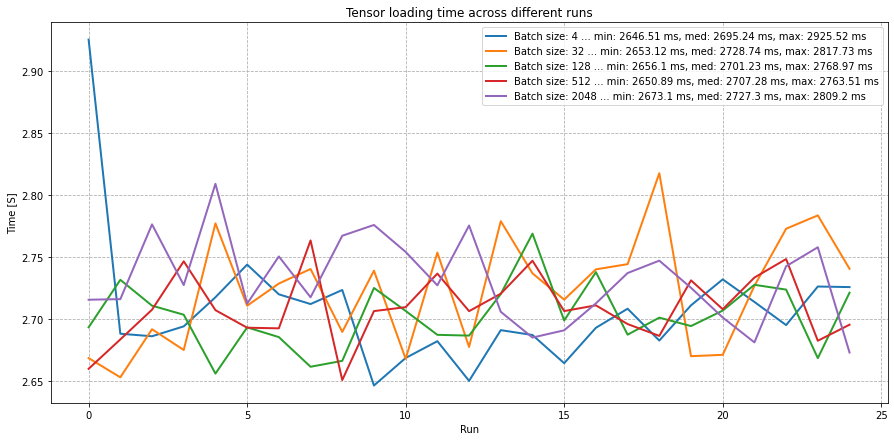

In [43]:
fig, ax = plt.subplots(figsize=(15, 7))
for batch_size in batch_sizes:
    df = df_dataset[(df_dataset["function_name"]=="open_random_batch") & (df_dataset["batch_size"]==batch_size)]
    elapsed = df["elapsed"]
#     all_elapsed.append(np.array(elapsed))
    ax.plot(range(len(elapsed)), 
            elapsed, 
            label=f"Batch size: {batch_size}" 
                  f" ... min: {np.round(min(elapsed) * 1000, 2)} ms, "
                  f"med: {np.round(np.median(elapsed) * 1000, 2)} ms, "
                  f"max: {np.round(max(elapsed) * 1000, 2)} ms",
            linewidth=2)
#     ax.plot(range(len(elapsed)), elapsed, label=f"Batch size: {batch_size}", linewidth=2)
ax.set_xlabel("Run")
ax.set_ylabel("Time [S]")
ax.set_title("Tensor loading time across different runs")
ax.grid(linestyle="--", which="both")
plt.legend(loc="upper right")

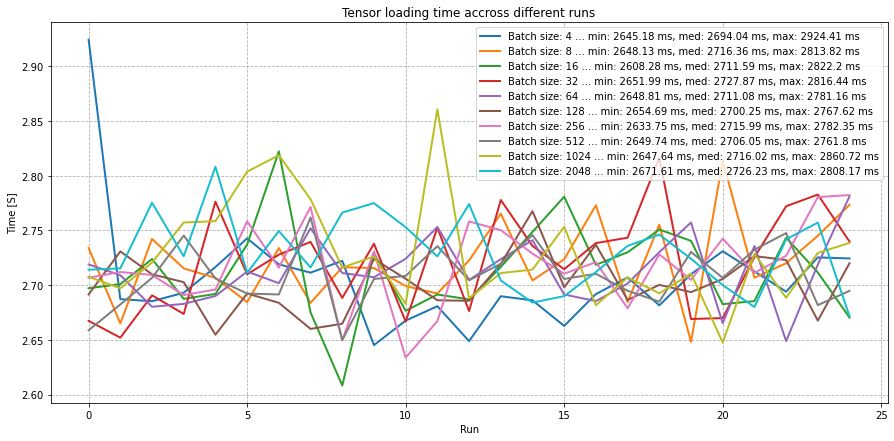

In [15]:
fig, ax = plt.subplots(figsize=(15, 7))
for batch_size in batch_sizes:
    df = df_dataset[(df_dataset["function_name"]=="load_random_tensor_on_gpu") & (df_dataset["batch_size"]==batch_size)]
    elapsed = df["elapsed"]
#     all_elapsed.append(np.array(elapsed))
    ax.plot(range(len(elapsed)), 
            elapsed, 
            label=f"Batch size: {batch_size}" 
                  f" ... min: {np.round(min(elapsed) * 1000, 2)} ms, "
                  f"med: {np.round(np.median(elapsed) * 1000, 2)} ms, "
                  f"max: {np.round(max(elapsed) * 1000, 2)} ms",
            linewidth=2)
#     ax.plot(range(len(elapsed)), elapsed, label=f"Batch size: {batch_size}", linewidth=2)
ax.set_xlabel("Run")
ax.set_ylabel("Time [S]")
ax.set_title("Tensor loading time across different runs")
ax.grid(linestyle="--", which="both")
plt.legend(loc="upper right")

Since `open_random_batch` calls `load_random_tensor_on_gpu` without performing any processing before it's call, the plots are (almost) identical, as expected!

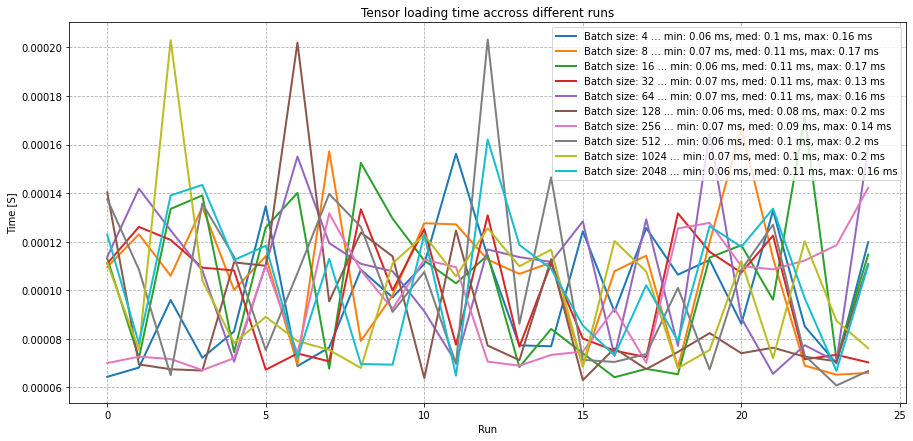

In [16]:
fig, ax = plt.subplots(figsize=(15, 7))
for batch_size in batch_sizes:
    df = df_dataset[(df_dataset["function_name"]=="just_tensor_load") & (df_dataset["batch_size"]==batch_size)]
    elapsed = df["elapsed"]
#     all_elapsed.append(np.array(elapsed))
    ax.plot(range(len(elapsed)), 
            elapsed, 
            label=f"Batch size: {batch_size}" 
                  f" ... min: {np.round(min(elapsed) * 1000, 2)} ms, "
                  f"med: {np.round(np.median(elapsed) * 1000, 2)} ms, "
                  f"max: {np.round(max(elapsed) * 1000, 2)} ms",
            linewidth=2)
#     ax.plot(range(len(elapsed)), elapsed, label=f"Batch size: {batch_size}", linewidth=2)
ax.set_xlabel("Run")
ax.set_ylabel("Time [S]")
ax.set_title("Tensor loading time across different runs")
ax.grid(linestyle="--", which="both")
plt.legend(loc="upper right")

The following plot shows the execution time of the `nothing` function, that essentially does nothing, just like calling `.cuda()` on a tensor that's already on the device should (https://pytorch.org/docs/stable/generated/torch.Tensor.cuda.html). While the plot above shows significantly lower batch loading time, in comparison to the previous case when it took around 2.5 S, now it's roughly 0.11 ms. This means that the function still performs a check, however, does not (or should not) perform any memory copying. 

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
for batch_size in batch_sizes:
    df = df_dataset[(df_dataset["function_name"]=="nothing") & (df_dataset["batch_size"]==batch_size)]
    elapsed = df["elapsed"]
#     all_elapsed.append(np.array(elapsed))
    ax.plot(range(len(elapsed)), 
            elapsed, 
            label=f"Batch size: {batch_size}" 
                  f" ... min: {np.round(min(elapsed) * 1000, 2)} ms, "
                  f"med: {np.round(np.median(elapsed) * 1000, 2)} ms, "
                  f"max: {np.round(max(elapsed) * 1000, 2)} ms",
            linewidth=2)
#     ax.plot(range(len(elapsed)), elapsed, label=f"Batch size: {batch_size}", linewidth=2)
ax.set_xlabel("Run")
ax.set_ylabel("Time [S]")
ax.set_title("Tensor loading time across different runs")
ax.grid(linestyle="--", which="both")
plt.legend(loc="upper right")

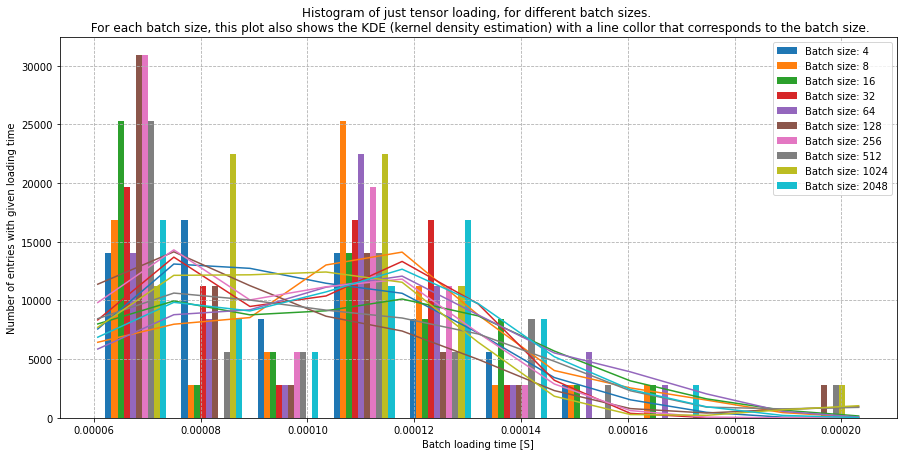

In [17]:
import scipy.stats as stats
fig, ax = plt.subplots(figsize=(15, 7))
elapsed_all = []
labels = []
for batch_size in batch_sizes:
    df = df_dataset[(df_dataset["function_name"]=="just_tensor_load") & (df_dataset["batch_size"]==batch_size)]
    elapsed_all.append(df["elapsed"])
    labels.append(f"Batch size: {batch_size}")
n, x, _  = ax.hist(elapsed_all, bins=10, label=labels, density=True)
ax.set_xlabel("Batch loading time [S]")
ax.set_ylabel("Number of entries with given loading time")
ax.set_title("Histogram of just tensor loading, for different batch sizes. \n For each batch size, this plot also shows the KDE (kernel density estimation) with a line collor that corresponds to the batch size.")
ax.grid(linestyle="--", which="both")
for elapsed in elapsed_all:
    density = stats.gaussian_kde(elapsed)
    ax.plot(x, density(x))
plt.legend()
# print(f"Median across all: {np.median(elapsed_all)}")

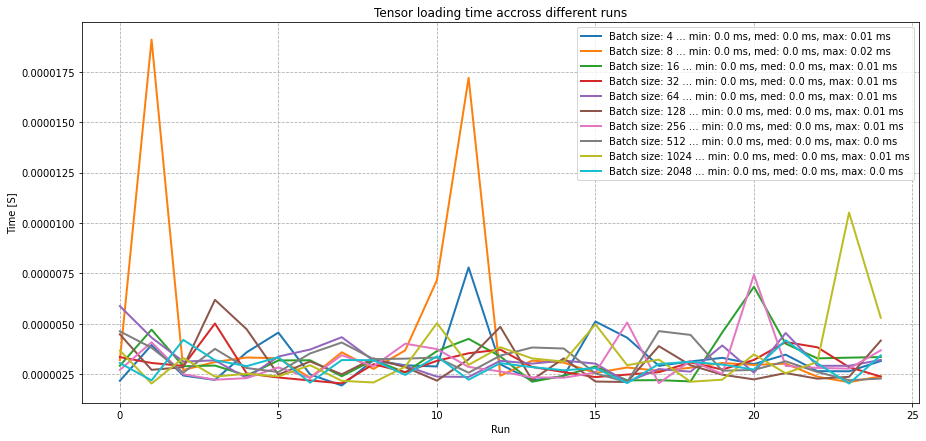

In [25]:
fig, ax = plt.subplots(figsize=(15, 7))
for batch_size in batch_sizes:
    df = df_dataset[(df_dataset["function_name"]=="nothing") & (df_dataset["batch_size"]==batch_size)]
    elapsed = df["elapsed"]
#     all_elapsed.append(np.array(elapsed))
    ax.plot(range(len(elapsed)), 
            elapsed, 
            label=f"Batch size: {batch_size}" 
                  f" ... min: {np.round(min(elapsed) * 1000, 2)} ms, "
                  f"med: {np.round(np.median(elapsed) * 1000, 2)} ms, "
                  f"max: {np.round(max(elapsed) * 1000, 2)} ms",
            linewidth=2)
#     ax.plot(range(len(elapsed)), elapsed, label=f"Batch size: {batch_size}", linewidth=2)
ax.set_xlabel("Run")
ax.set_ylabel("Time [S]")
ax.set_title("Tensor loading time across different runs")
ax.ticklabel_format(style='plain')
ax.grid(linestyle="--", which="both")
plt.legend(loc="upper right")

## Multiprocessing

In [82]:
output_base_folder = Path("/iarai/home/ivan.svogor/git/storage-benchmarking/benchmark_output/batches-mp-images/")
df_dataset = parse_logs(output_base_folder, folder_filter="*benchmark*")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3219/3219 [01:07<00:00, 47.45it/s]


In [83]:
unique_runs = np.unique(df_dataset["run"])
batch_sizes = np.unique(df_dataset["batch_size"])
print(f"Batch sizes: {batch_sizes}")
function_names = np.unique(df_dataset["function_name"])
print(f"Function names: {function_names}")
batch_pools = np.unique(df_dataset["pool_size"])
print(f"Pool sizes: {batch_pools}")

Batch sizes: [   4   32  128  512 2048]
Function names: ['just_tensor_load' 'load_random_local_image_to_gpu' 'nothing'
 'open_random_batch']
Pool sizes: [ 1  2  4  8 16 32]


**NOTE**:With pool size >32 and batch size 2048, we get `RuntimeError: CUDA error: out of memory`

**IMPORTANT**

Implementation note, while performing multiprocessing we use:

`pool.starmap(self.run, [(action_name, action)] * self.pool_size)`

Which means that we are in parallel downloading the "pool size" of batches. So, to get an estimate of the loading time for a SINGLE batch, we must divide with `pool_size`.

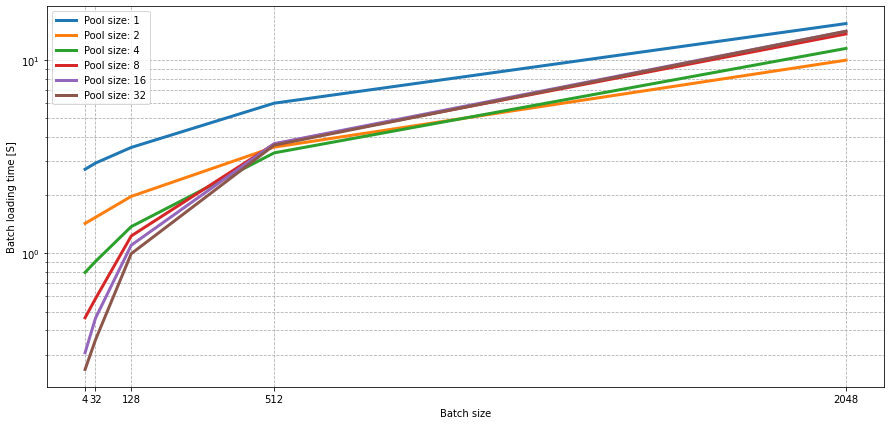

In [104]:
fig, ax = plt.subplots(figsize=(15, 7))
for pool in batch_pools:
    medians = []
    for batch_size in batch_sizes:
        df = df_dataset[(df_dataset["function_name"]=="open_random_batch") & 
                        (df_dataset["pool_size"]==pool) &
                        (df_dataset["batch_size"]==batch_size)]  
        medians.append(np.median(df["elapsed"]) / pool)
    ax.plot(batch_sizes, medians, label=f"Pool size: {pool}", linewidth=3)
    ax.set_ylabel("Batch loading time [S]")
    ax.set_xlabel("Batch size")
    ax.set_xticks(batch_sizes)
    ax.grid(linestyle="--", which="both")
    plt.legend()
    ax.set_yscale("log")

Previous plot displays how different batch sizes and pool sizes reflect the batch loading time (to a GPU). X asis is the batch size, and one can notice that for lines of the same color (that represent different thread pool sizes) are relatively constant, meaning that the batch size doesn't influence batch loading time as much as one would expect. Similar behavior can be observed in the following plot for the `just_tensor_load` function that should perform the copying to the GPU memory. 
However, pool size has a much greater impact on the loading time: **with the increase of the thread pool, the loading time increases.** 

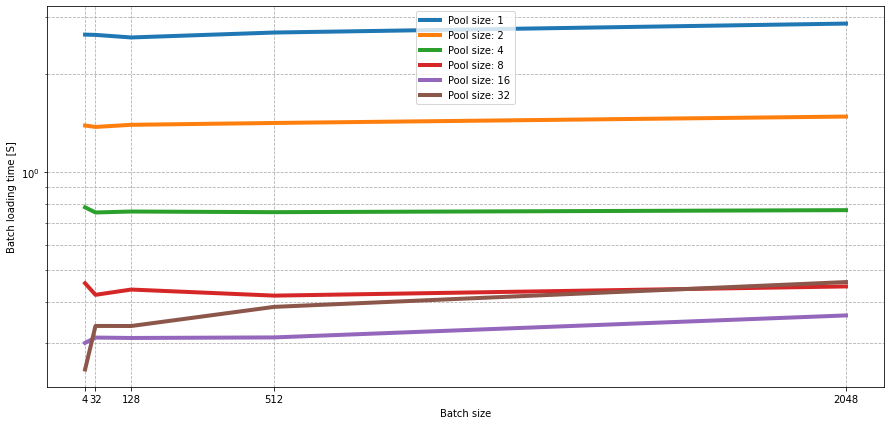

In [106]:
fig, ax = plt.subplots(figsize=(15, 7))
for pool in batch_pools:
    medians = []
    for batch_size in batch_sizes:
        df = df_dataset[(df_dataset["function_name"]=="just_tensor_load") & 
                        (df_dataset["pool_size"]==pool) &
                        (df_dataset["batch_size"]==batch_size)]  
        medians.append(np.median(df["elapsed"]) / pool)
    ax.plot(batch_sizes, medians, label=f"Pool size: {pool}", linewidth=4)
    ax.set_ylabel("Batch loading time [S]")
    ax.set_xlabel("Batch size")
    ax.set_xticks(batch_sizes)
    ax.grid(linestyle="--", which="both")
    plt.legend()
    ax.set_yscale("log")

Furthermore, on the following plot, we have the thread pool size in focus. Once again, we can notice that batch size makes relatively little difference to the loading time. 

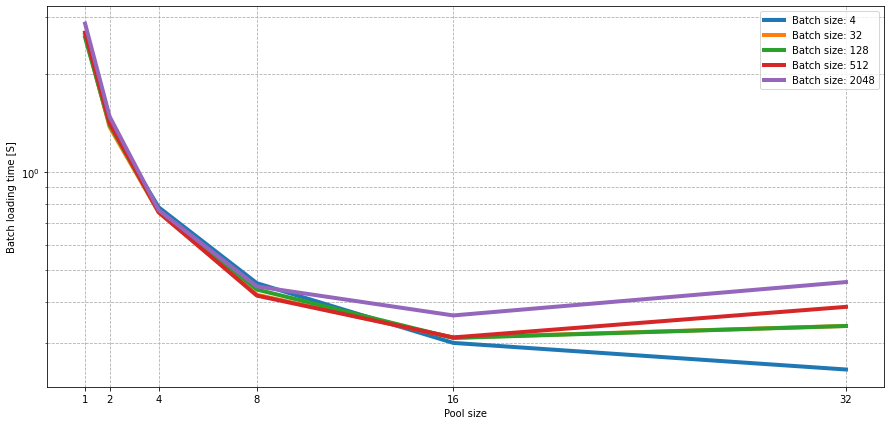

In [105]:
fig, ax = plt.subplots(figsize=(15, 7))
for batch_size in batch_sizes:
    medians = []
    for pool in batch_pools:
        df = df_dataset[(df_dataset["function_name"]=="just_tensor_load") & 
                        (df_dataset["pool_size"]==pool) &
                        (df_dataset["batch_size"]==batch_size)]  
        medians.append(np.median(df["elapsed"]) / pool)
    ax.plot(batch_pools, medians, label=f"Batch size: {batch_size}", linewidth=4)
    ax.set_ylabel("Batch loading time [S]")
    ax.set_xlabel("Pool size")
    ax.set_xticks(batch_pools)
    ax.grid(linestyle="--", which="both")
    plt.legend()
    ax.set_yscale("log")

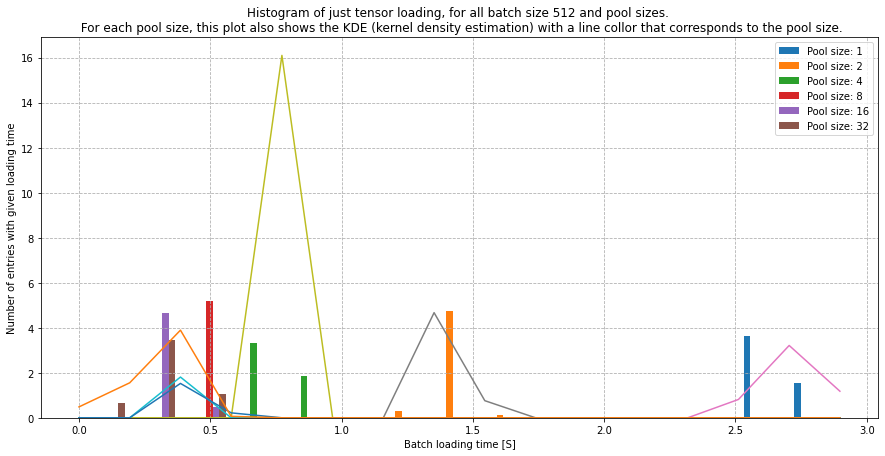

In [112]:
fig, ax = plt.subplots(figsize=(15, 7))
elapsed_all = []
labels = []
for pool in batch_pools:
    df = df_dataset[(df_dataset["function_name"]=="just_tensor_load") & 
                    (df_dataset["pool_size"]==pool)]
    elapsed_all.append(df["elapsed"] / pool)
    labels.append(f"Pool size: {pool}")
n, x, _  = ax.hist(elapsed_all, bins=15, label=labels, density=True)
ax.set_xlabel("Batch loading time [S]")
ax.set_ylabel("Number of entries with given loading time")
ax.set_title("Histogram of just tensor loading, for all batch size 512 and pool sizes. \n For each pool size, this plot also shows the KDE (kernel density estimation) with a line collor that corresponds to the pool size.")
ax.grid(linestyle="--", which="both")
for elapsed in elapsed_all:
    density = stats.gaussian_kde(elapsed)
    ax.plot(x, density(x))
plt.legend()